In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
data = pd.read_csv("datasets/dataset_train.csv")
data['Birthday'] = pd.to_datetime(data['Birthday'])
data['Birthday Weekday'] = data['Birthday'].dt.dayofweek
data['Birthday Year'] = data['Birthday'].dt.year
data['Birthday Month'] = data['Birthday'].dt.month
data = data.drop(columns=['Index', 'First Name', 'Last Name', 'Birthday', 'Defense Against the Dark Arts', 'Arithmancy', 'Care of Magical Creatures'])
data

,Hogwarts House,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Weekday,Birthday Year,Birthday Month
0,Ravenclaw,Left,-487.886086,5.727180,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,-232.79405,-26.89,3,2000,3
1,Slytherin,Right,-552.060507,-5.987446,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,-252.18425,-113.45,3,1999,10
2,Ravenclaw,Left,-366.076117,7.725017,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-227.34265,30.42,2,1999,11
3,Gryffindor,Left,697.742809,-6.497214,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-256.84675,200.64,5,2000,8
4,Gryffindor,Left,436.775204,-7.820623,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-256.38730,157.98,6,1998,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Gryffindor,Right,354.280086,-4.541837,5.702,-497.235066,618.220213,-5.231721,964.219853,3.389086,-250.39401,185.83,4,2001,9
1596,Slytherin,Left,367.531174,6.061064,1.757,-643.271092,445.827565,2.238112,1056.147366,5.825263,-246.42719,44.80,3,1998,3
1597,Gryffindor,Right,544.018925,-3.203269,6.065,-385.150457,635.211486,-5.984257,953.866685,1.709808,-251.63679,198.47,6,1999,10
1598,Hufflepuff,Left,453.676219,3.442831,6.738,-831.741123,383.444937,3.813111,1087.949205,3.904100,-246.19072,-76.81,4,2001,9


<Axes: xlabel='Hogwarts House', ylabel='Birthday Weekday'>

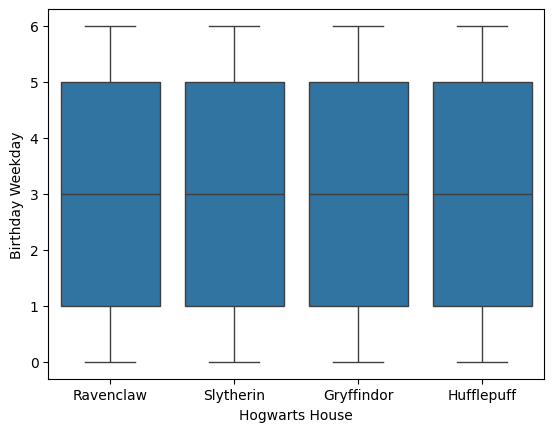

In [3]:
sns.boxplot(data=data, x='Hogwarts House', y='Birthday Weekday')

<Axes: xlabel='Hogwarts House', ylabel='Birthday Month'>

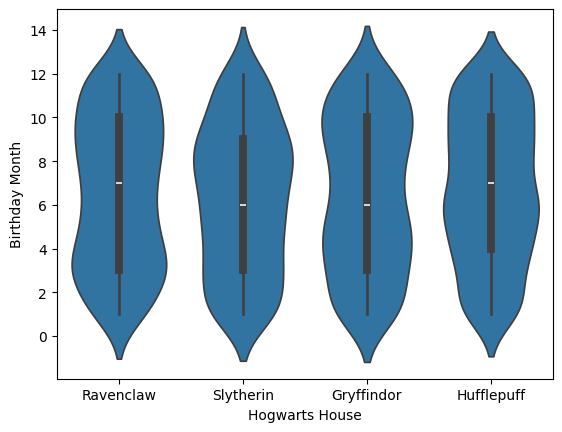

In [4]:
sns.violinplot(data=data, x='Hogwarts House', y='Birthday Month')

<Axes: xlabel='Hogwarts House', ylabel='Birthday Year'>

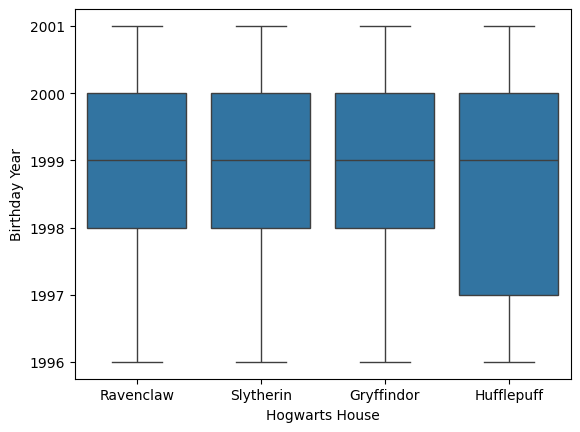

In [5]:
sns.boxplot(data=data, x='Hogwarts House', y='Birthday Year')

In [6]:
X = data.drop(columns=['Hogwarts House', 'Birthday Weekday'])
data['House Slytherin'] = (data['Hogwarts House'] == 'Slytherin').astype(int)
data['House Hufflepuff'] = (data['Hogwarts House'] == 'Hufflepuff').astype(int)
data['House Gryffindor'] = (data['Hogwarts House'] == 'Gryffindor').astype(int)
data['House Ravenclaw'] = (data['Hogwarts House'] == 'Ravenclaw').astype(int)
Y = data[[col for col in data.columns if col.startswith('House ')]]
display(X)
display(Y)

,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
0,Left,-487.886086,5.727180,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,-232.79405,-26.89,2000,3
1,Right,-552.060507,-5.987446,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,-252.18425,-113.45,1999,10
2,Left,-366.076117,7.725017,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-227.34265,30.42,1999,11
3,Left,697.742809,-6.497214,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-256.84675,200.64,2000,8
4,Left,436.775204,-7.820623,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-256.38730,157.98,1998,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Right,354.280086,-4.541837,5.702,-497.235066,618.220213,-5.231721,964.219853,3.389086,-250.39401,185.83,2001,9
1596,Left,367.531174,6.061064,1.757,-643.271092,445.827565,2.238112,1056.147366,5.825263,-246.42719,44.80,1998,3
1597,Right,544.018925,-3.203269,6.065,-385.150457,635.211486,-5.984257,953.866685,1.709808,-251.63679,198.47,1999,10
1598,Left,453.676219,3.442831,6.738,-831.741123,383.444937,3.813111,1087.949205,3.904100,-246.19072,-76.81,2001,9


,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1595,0,0,1,0
1596,1,0,0,0
1597,0,0,1,0
1598,0,1,0,0


# Missing values

In [7]:
X.isna().sum() / len(X) * 100

Best Hand           0.0000
Astronomy           2.0000
Herbology           2.0625
Divination          2.4375
Muggle Studies      2.1875
Ancient Runes       2.1875
History of Magic    2.6875
Transfiguration     2.1250
Potions             1.8750
Charms              0.0000
Flying              0.0000
Birthday Year       0.0000
Birthday Month      0.0000
dtype: float64

In [8]:
Y.isna().sum() / len(Y) * 100

House Slytherin     0.0
House Hufflepuff    0.0
House Gryffindor    0.0
House Ravenclaw     0.0
dtype: float64

In [9]:
(Y['House Slytherin'] + Y['House Gryffindor'] + Y['House Ravenclaw'] + Y['House Hufflepuff']).value_counts()

1    1600
Name: count, dtype: int64

# Preprocessings

In [10]:
data.groupby('Hogwarts House').mean(numeric_only=True)

,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Weekday,Birthday Year,Birthday Month,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw
Hogwarts House,,,,,,,,,,,,,,,,,
Gryffindor,493.336646,-4.783906,4.901349,-501.483149,596.934487,-4.814947,951.134696,2.938132,-252.731046,189.024526,3.042813,1998.749235,6.434251,0.0,0.0,1.0,0.0
Hufflepuff,497.708002,4.919408,5.021665,-498.350774,400.147454,5.010295,1049.562165,4.960686,-244.347364,-7.085690,2.965974,1998.750473,6.724008,0.0,1.0,0.0,0.0
Ravenclaw,-480.043083,5.021857,4.987894,489.111967,597.749968,4.915960,1050.334282,6.972413,-231.080576,-3.979797,3.022573,1998.977427,6.530474,0.0,0.0,0.0,1.0
Slytherin,-496.333927,-4.775624,-4.814491,-478.731883,401.813874,4.967681,1051.898698,9.470743,-249.593194,-70.321661,3.079734,1998.734219,6.289037,1.0,0.0,0.0,0.0


In [11]:
data

,Hogwarts House,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Weekday,Birthday Year,Birthday Month,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw
0,Ravenclaw,Left,-487.886086,5.727180,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,-232.79405,-26.89,3,2000,3,0,0,0,1
1,Slytherin,Right,-552.060507,-5.987446,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,-252.18425,-113.45,3,1999,10,1,0,0,0
2,Ravenclaw,Left,-366.076117,7.725017,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-227.34265,30.42,2,1999,11,0,0,0,1
3,Gryffindor,Left,697.742809,-6.497214,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-256.84675,200.64,5,2000,8,0,0,1,0
4,Gryffindor,Left,436.775204,-7.820623,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-256.38730,157.98,6,1998,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Gryffindor,Right,354.280086,-4.541837,5.702,-497.235066,618.220213,-5.231721,964.219853,3.389086,-250.39401,185.83,4,2001,9,0,0,1,0
1596,Slytherin,Left,367.531174,6.061064,1.757,-643.271092,445.827565,2.238112,1056.147366,5.825263,-246.42719,44.80,3,1998,3,1,0,0,0
1597,Gryffindor,Right,544.018925,-3.203269,6.065,-385.150457,635.211486,-5.984257,953.866685,1.709808,-251.63679,198.47,6,1999,10,0,0,1,0
1598,Hufflepuff,Left,453.676219,3.442831,6.738,-831.741123,383.444937,3.813111,1087.949205,3.904100,-246.19072,-76.81,4,2001,9,0,1,0,0


In [12]:
X_train = pd.DataFrame()
groups = data.groupby('Hogwarts House').groups
for group in groups.values():
    print(group)
    group_sample = X.iloc[group].sample(frac=0.75, random_state=0)
    X_train = pd.concat([X_train, group_sample])
    display(X_train)
X_train['Hogwarts House'] = data.loc[X_train.index, ['Hogwarts House']]
display(X_train['Hogwarts House'].value_counts() / len(X_train))
display(data['Hogwarts House'].value_counts() / len(data))

Index([   3,    4,    6,    8,   16,   17,   20,   21,   28,   31,
       ...
       1547, 1549, 1554, 1565, 1566, 1573, 1578, 1592, 1595, 1597],
      dtype='int64', length=327)


,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
552,Left,477.002654,-4.133030,5.032,-688.334135,604.170812,-6.149529,954.040007,2.367920,-253.17175,208.01,1998,3
294,Right,742.277233,-5.877095,4.495,-618.590812,560.152424,-2.227252,960.897188,6.762301,-254.44193,175.93,2001,5
670,Right,535.160189,-7.081555,4.438,-130.318679,563.092099,-2.861767,943.261243,3.050693,-253.23259,143.98,2000,6
1154,Left,429.615183,-5.875546,4.576,-724.519440,552.231491,-5.422822,939.550946,1.339359,-254.27238,193.60,1998,10
699,Right,741.889374,-6.014812,4.301,-393.140577,572.622514,NaN,942.014576,NaN,-255.05659,181.62,2000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,Right,600.473294,-5.869779,4.132,-658.691115,572.727918,-5.203977,929.558009,2.480756,-255.57869,217.21,1998,3
1448,Right,-254.245351,3.706746,5.738,504.047188,621.993895,5.149581,1051.651816,9.859910,-231.87388,21.56,1997,6
461,Left,640.205237,-5.677365,3.688,-484.856420,601.062126,-5.425040,922.028547,1.991429,-256.25905,217.11,2000,10
1578,Right,419.360183,-6.242092,3.989,-310.695714,620.726433,-3.644746,954.144476,NaN,-253.18160,150.95,1998,12


Index([   7,    9,   10,   11,   12,   19,   23,   25,   27,   29,
       ...
       1563, 1570, 1572, 1580, 1585, 1587, 1589, 1594, 1598, 1599],
      dtype='int64', length=529)


,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
552,Left,477.002654,-4.133030,5.032,-688.334135,604.170812,-6.149529,954.040007,2.367920,-253.17175,208.01,1998,3
294,Right,742.277233,-5.877095,4.495,-618.590812,560.152424,-2.227252,960.897188,6.762301,-254.44193,175.93,2001,5
670,Right,535.160189,-7.081555,4.438,-130.318679,563.092099,-2.861767,943.261243,3.050693,-253.23259,143.98,2000,6
1154,Left,429.615183,-5.875546,4.576,-724.519440,552.231491,-5.422822,939.550946,1.339359,-254.27238,193.60,1998,10
699,Right,741.889374,-6.014812,4.301,-393.140577,572.622514,NaN,942.014576,NaN,-255.05659,181.62,2000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Right,236.886191,3.889556,NaN,-334.625568,408.331272,2.625982,1048.568160,-0.246103,-244.86997,-57.61,2000,2
550,Left,509.966220,3.549710,6.223,-576.182798,364.994848,6.589345,1065.850713,4.189629,-245.38901,-89.49,1997,9
166,Left,338.822931,7.329864,4.189,-616.839179,426.949753,2.327245,1052.164438,3.416829,-243.45278,38.90,1999,4
103,Right,529.303005,4.204821,6.890,-511.896277,386.227460,6.335260,1054.676835,4.540174,-243.63460,-50.50,1997,9


Index([   0,    2,   14,   15,   18,   22,   24,   32,   34,   35,
       ...
       1567, 1568, 1569, 1574, 1575, 1576, 1577, 1582, 1590, 1593],
      dtype='int64', length=443)


,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
552,Left,477.002654,-4.133030,5.032,-688.334135,604.170812,-6.149529,954.040007,2.367920,-253.17175,208.01,1998,3
294,Right,742.277233,-5.877095,4.495,-618.590812,560.152424,-2.227252,960.897188,6.762301,-254.44193,175.93,2001,5
670,Right,535.160189,-7.081555,4.438,-130.318679,563.092099,-2.861767,943.261243,3.050693,-253.23259,143.98,2000,6
1154,Left,429.615183,-5.875546,4.576,-724.519440,552.231491,-5.422822,939.550946,1.339359,-254.27238,193.60,1998,10
699,Right,741.889374,-6.014812,4.301,-393.140577,572.622514,NaN,942.014576,NaN,-255.05659,181.62,2000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,Right,-374.140732,6.212944,6.656,601.525774,613.124830,4.572754,1062.541138,7.381516,-228.96442,7.14,1997,5
530,Right,-313.012958,5.039512,6.272,498.212844,591.453317,4.878161,1069.161901,7.797000,-231.09474,-15.45,2000,4
697,Left,-599.102083,4.321074,3.692,NaN,531.947092,5.393248,1052.359602,5.641110,-231.97215,-35.16,1997,4
104,Right,-316.958196,7.056763,6.811,439.411685,635.974144,7.627176,1051.755078,9.270982,-228.81269,-9.05,2000,6


Index([   1,    5,   13,   26,   38,   48,   51,   52,   55,   57,
       ...
       1550, 1571, 1579, 1581, 1583, 1584, 1586, 1588, 1591, 1596],
      dtype='int64', length=301)


,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
552,Left,477.002654,-4.133030,5.032,-688.334135,604.170812,-6.149529,954.040007,2.367920,-253.17175,208.01,1998,3
294,Right,742.277233,-5.877095,4.495,-618.590812,560.152424,-2.227252,960.897188,6.762301,-254.44193,175.93,2001,5
670,Right,535.160189,-7.081555,4.438,-130.318679,563.092099,-2.861767,943.261243,3.050693,-253.23259,143.98,2000,6
1154,Left,429.615183,-5.875546,4.576,-724.519440,552.231491,-5.422822,939.550946,1.339359,-254.27238,193.60,1998,10
699,Right,741.889374,-6.014812,4.301,-393.140577,572.622514,NaN,942.014576,NaN,-255.05659,181.62,2000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,Right,-507.715746,-4.997610,-5.637,-443.781855,386.058513,6.990603,1019.526453,7.696268,-251.06254,-94.84,1998,9
1063,Left,-448.911475,-5.148501,-6.922,-516.460366,376.313070,1.457759,1072.470240,6.891704,-254.66100,-85.57,1997,12
51,Right,-508.096166,-5.315117,-7.952,-460.669746,373.290032,2.211949,1080.114992,9.819558,-253.02188,-63.61,1997,11
378,Right,-390.876282,-7.134160,-5.132,-538.915172,401.358926,6.838287,1049.399845,11.235190,-252.32607,-108.50,1997,6


Hogwarts House
Hufflepuff    0.330833
Ravenclaw     0.276667
Gryffindor    0.204167
Slytherin     0.188333
Name: count, dtype: float64

Hogwarts House
Hufflepuff    0.330625
Ravenclaw     0.276875
Gryffindor    0.204375
Slytherin     0.188125
Name: count, dtype: float64

In [13]:
def ft_train_test_split(X, Y, test_size=0.25, stratify_col=None, random_state=None):
    if not stratify_col:
        X_train = X.sample(frac=1-test_size, random_state=random_state)
    else:
        groups = X.groupby(stratify_col).groups
        X_train = pd.DataFrame()
        for group in groups.values():
            group_sample = X.iloc[group].sample(frac=1-test_size, random_state=random_state)
            X_train = pd.concat([X_train, group_sample])
    X_test = X.iloc[X.index.difference(X_train.index)]
    Y_train = Y.iloc[X_train.index]
    Y_test = Y.iloc[Y.index.difference(Y_train.index)]
    return (X_train, X_test, Y_train, Y_test)


In [14]:
def ft_imputer(dataframe, columns, agg_function):
    copy = dataframe.copy()
    for column in columns:
        value = agg_function(copy[column])
        copy[column] = copy[column].fillna(value)
    return copy[columns]

In [15]:
def ft_standard_scaler(dataframe, columns):
    copy = dataframe.copy()
    for column in columns:
        mean = np.mean(dataframe[column])
        std = np.std(dataframe[column])
        copy[column] = (copy[column] - mean) / std
    return copy[columns]

In [16]:
def ft_one_hot_encoding(dataframe, columns, drop_last=True):
    copy = dataframe.copy()
    new_columns = []
    for column in columns:
        values = np.unique(copy[column]).astype(str)
        if drop_last:
            values = values[:-1]
        for value in values:
            copy[column+'_'+value] = (copy[column].astype(str) == str(value)).astype(int)
            new_columns.append(column+'_'+value)
    return copy[new_columns]

In [17]:
X_train, X_test, Y_train, Y_test = ft_train_test_split(X, Y)
display(X_train)
display(X_test)
display(Y_train)
display(Y_test)

,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
1436,Right,-489.769045,-6.613031,-4.261,-544.838660,377.650315,7.829515,1033.155115,8.453327,-251.29157,-135.83,1997,7
457,Right,-613.217960,2.452755,3.879,451.839455,544.037549,5.162977,1056.942851,7.113384,-232.27721,-33.94,1997,8
1276,Left,183.960071,11.612895,NaN,-317.916569,307.859536,1.854336,1038.968179,-4.697484,-245.70331,-12.03,1997,3
708,Right,447.635123,-6.031394,3.599,-602.490146,586.415145,-4.192878,957.139180,3.636007,-254.90392,157.15,1998,6
750,Left,437.381165,6.623410,5.481,-509.989770,404.643981,6.062806,1047.523450,3.950062,-242.88413,-26.12,1998,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Left,-440.338760,6.311157,6.853,646.528726,627.451156,3.221958,1056.024660,4.614669,-229.77604,-4.98,1999,3
257,Left,-374.574049,-6.723347,-4.152,-361.592719,436.855595,6.673904,1018.391264,8.752264,-251.86010,-96.80,1998,4
1282,Right,-583.086754,2.245236,5.079,945.313633,601.733010,NaN,1066.576871,6.365428,-231.31548,-101.79,1997,6
1429,Right,-609.380830,6.858854,3.784,594.085870,576.852447,4.748019,1069.890742,7.633853,-228.64198,3.92,2001,9


,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Year,Birthday Month
15,Left,-447.649812,4.046727,4.949,810.154483,615.531088,3.653495,1075.853850,9.622899,-229.38229,17.00,2001,10
16,Left,470.653757,-5.518264,4.425,-434.293266,596.610089,-4.161823,967.223912,5.027415,-252.27344,174.27,1997,9
17,Left,651.198749,-4.820771,4.357,-468.284723,626.372886,-5.206672,935.579290,3.063207,-254.92326,212.37,2001,5
18,Right,-151.088209,6.871857,7.906,645.447451,607.442729,6.317446,1091.054831,11.708777,-226.76896,11.22,2000,3
23,Left,673.167110,0.131516,9.421,-709.696428,461.896734,0.531823,1073.585204,6.346027,-245.83067,23.46,1999,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,Right,-626.623309,3.117287,5.025,778.083678,625.241315,5.777496,1056.820016,7.524604,-230.11765,-52.11,1999,12
1581,Left,-656.740586,-5.019345,-5.950,-638.746529,353.912068,5.430560,1084.243192,12.382600,-247.90805,-73.55,2000,5
1588,Right,-492.510311,-2.208650,-7.270,-622.936567,NaN,2.201186,1069.012391,9.117247,-250.91192,-19.50,1999,4
1589,Left,708.202206,4.850931,5.660,-504.777873,417.520448,4.568628,1046.345436,6.272776,-245.03263,28.70,2001,6


,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw
1436,1,0,0,0
457,0,0,0,1
1276,0,1,0,0
708,0,0,1,0
750,0,1,0,0
...,...,...,...,...
690,0,0,0,1
257,1,0,0,0
1282,1,0,0,0
1429,0,0,0,1


,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw
15,0,0,0,1
16,0,0,1,0
17,0,0,1,0
18,0,0,0,1
23,0,1,0,0
...,...,...,...,...
1577,0,0,0,1
1581,1,0,0,0
1588,1,0,0,0
1589,0,1,0,0


In [18]:
numerical_cols = ['Astronomy', 'Herbology', 'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic', 'Transfiguration', 'Potions', 'Charms', 'Flying', 'Birthday Year']
categorical_cols = ['Birthday Month', 'Best Hand']

X_train_preprocessed = X_train.loc[:,numerical_cols]
X_train_preprocessed[numerical_cols] = ft_imputer(X_train, numerical_cols, np.mean)
X_train_preprocessed[numerical_cols] = ft_standard_scaler(X_train_preprocessed, numerical_cols)
X_train_preprocessed = pd.concat([X_train_preprocessed, ft_one_hot_encoding(X_train, categorical_cols)], axis=1)
X_train_preprocessed

,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,...,Birthday Month_3,Birthday Month_4,Birthday Month_5,Birthday Month_6,Birthday Month_7,Birthday Month_8,Birthday Month_9,Birthday Month_10,Birthday Month_11,Best Hand_Left
1436,-1.047560,-1.506050,-1.865172e+00,-0.657087,-1.126661,1.109430,0.086802,0.812228,-0.901256,-1.615370,...,0,0,0,0,1,0,0,0,0,0
457,-1.287894,0.249969,1.584863e-01,1.434422,0.460578,0.506124,0.625803,0.385397,1.270170,-0.583554,...,0,0,0,0,0,1,0,0,0,0
1276,0.264077,2.024265,-1.104035e-16,-0.180896,-1.792425,-0.242458,0.218519,-3.376887,-0.263081,-0.361676,...,1,0,0,0,0,0,0,0,0,1
708,0.777407,-1.393388,8.887645e-02,-0.778068,0.864837,-1.610644,-1.635628,-0.722302,-1.313784,1.351571,...,0,0,0,1,0,0,0,0,0,0
750,0.757444,1.057814,5.567542e-01,-0.583958,-0.869157,0.709711,0.412371,-0.622261,0.058868,-0.504362,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,-0.951327,0.997332,8.978425e-01,1.842973,1.256297,0.066967,0.604998,-0.410555,1.555802,-0.290282,...,1,0,0,0,0,0,0,0,0,1
257,-0.823295,-1.527418,-1.838074e+00,-0.272549,-0.561876,0.847972,-0.247729,0.907453,-0.966182,-1.220122,...,0,1,0,0,0,0,0,0,0,1
1282,-1.229233,0.209773,4.568143e-01,2.469968,1.010960,0.000000,0.844098,0.147140,1.379999,-1.270655,...,0,0,0,1,0,0,0,0,0,0
1429,-1.280423,1.103419,1.348687e-01,1.732923,0.773614,0.412239,0.919187,0.551189,1.685311,-0.200154,...,0,0,0,0,0,0,1,0,0,0


In [19]:
data_train = data.iloc[X_train.index,:]
data_train

,Hogwarts House,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Weekday,Birthday Year,Birthday Month,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw
1436,Slytherin,Right,-489.769045,-6.613031,-4.261,-544.838660,377.650315,7.829515,1033.155115,8.453327,-251.29157,-135.83,3,1997,7,1,0,0,0
457,Ravenclaw,Right,-613.217960,2.452755,3.879,451.839455,544.037549,5.162977,1056.942851,7.113384,-232.27721,-33.94,5,1997,8,0,0,0,1
1276,Hufflepuff,Left,183.960071,11.612895,NaN,-317.916569,307.859536,1.854336,1038.968179,-4.697484,-245.70331,-12.03,5,1997,3,0,1,0,0
708,Gryffindor,Right,447.635123,-6.031394,3.599,-602.490146,586.415145,-4.192878,957.139180,3.636007,-254.90392,157.15,6,1998,6,0,0,1,0
750,Hufflepuff,Left,437.381165,6.623410,5.481,-509.989770,404.643981,6.062806,1047.523450,3.950062,-242.88413,-26.12,3,1998,11,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Ravenclaw,Left,-440.338760,6.311157,6.853,646.528726,627.451156,3.221958,1056.024660,4.614669,-229.77604,-4.98,0,1999,3,0,0,0,1
257,Slytherin,Left,-374.574049,-6.723347,-4.152,-361.592719,436.855595,6.673904,1018.391264,8.752264,-251.86010,-96.80,5,1998,4,1,0,0,0
1282,Slytherin,Right,-583.086754,2.245236,5.079,945.313633,601.733010,NaN,1066.576871,6.365428,-231.31548,-101.79,6,1997,6,1,0,0,0
1429,Ravenclaw,Right,-609.380830,6.858854,3.784,594.085870,576.852447,4.748019,1069.890742,7.633853,-228.64198,3.92,3,2001,9,0,0,0,1


In [20]:
# from logreg_train import LogReg

# logreg = LogReg(X_preprocessed.shape[1], lr=0.001)
# logreg.weights


In [21]:
# logreg(X_preprocessed)

In [22]:
# for i in range(100):
    # logreg.train_step(X_preprocessed, Y['House Slytherin'])

In [23]:
# logreg.weights

In [24]:
# logreg(X_preprocessed)

In [25]:
# pd.DataFrame(logreg.losses)

In [26]:
# px.line(pd.DataFrame(logreg.losses), x = 'step', y = 'loss')

In [27]:
# Y['predict_Slytherin'] = logreg.predict(X_preprocessed)
# Y[['House Slytherin', 'predict_Slytherin']]

In [28]:
# Y['House Slytherin'].value_counts()

In [29]:
# Y['predict_Slytherin'].value_counts()

In [30]:
from logreg_train import SortingHat

sorting_hat = SortingHat(X_train_preprocessed.shape[1], lr=0.005)
sorting_hat

In [31]:
X_test_preprocessed = X_test.loc[:,numerical_cols]
X_test_preprocessed[numerical_cols] = ft_imputer(X_test, numerical_cols, np.mean)
X_test_preprocessed[numerical_cols] = ft_standard_scaler(X_test_preprocessed, numerical_cols)
X_test_preprocessed = pd.concat([X_test_preprocessed, ft_one_hot_encoding(X_test, categorical_cols)], axis=1)
X_test_preprocessed

,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,...,Birthday Month_3,Birthday Month_4,Birthday Month_5,Birthday Month_6,Birthday Month_7,Birthday Month_8,Birthday Month_9,Birthday Month_10,Birthday Month_11,Best Hand_Left
15,-0.892170,0.574741,0.475173,2.055203,1.131934,0.138013,1.032944,1.159539,1.571976,0.002370,...,0,0,0,0,0,0,0,1,0,1
16,0.881254,-1.276389,0.354034,-0.469415,0.953169,-1.726310,-1.550897,-0.349260,-1.013753,1.677495,...,0,0,0,0,0,0,1,0,0,1
17,1.229922,-1.141402,0.338314,-0.538374,1.234367,-1.975556,-2.303588,-0.994152,-1.313070,2.083308,...,0,0,1,0,0,0,0,0,0,1
18,-0.319451,1.121494,1.158776,1.721061,1.055516,0.773492,1.394511,1.844379,1.867171,-0.059194,...,1,0,0,0,0,0,0,0,0,0
23,1.272347,-0.182977,1.509016,-1.028127,-0.319599,-0.606654,0.978983,0.083670,-0.285993,0.071177,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,-1.237803,0.394865,0.492743,1.990141,1.223676,0.644688,0.580211,0.470623,1.488911,-0.733739,...,0,0,0,0,0,0,0,0,0,0
1581,-1.295965,-1.179832,-2.044471,-0.884190,-1.339836,0.561927,1.232491,2.065610,-0.520649,-0.962102,...,0,0,1,0,0,0,0,0,0,1
1588,-0.978804,-0.635873,-2.349630,-0.852117,0.000000,-0.208431,0.870215,0.993523,-0.859959,-0.386401,...,0,1,0,0,0,0,0,0,0,0
1589,1.340006,0.730380,0.639543,-0.612407,-0.738865,0.356316,0.331065,0.059620,-0.195849,0.126990,...,0,0,0,1,0,0,0,0,0,1


In [32]:
for i in range(1000):
    sorting_hat.train_step(X_train_preprocessed, Y_train, X_test_preprocessed, Y_test)

In [33]:
data_train['pred'] = sorting_hat.predict(X_train_preprocessed)

/tmp/ipykernel_573012/769043894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['pred'] = sorting_hat.predict(X_train_preprocessed)


In [34]:
sorting_hat(X_train_preprocessed)

array([[0.86840534, 0.09474976, 0.01855902, ..., 0.05810368, 0.04827387,
        0.03818064],
       [0.15021575, 0.07893603, 0.92625265, ..., 0.04560208, 0.08035685,
        0.83077928],
       [0.01837805, 0.01521744, 0.04865088, ..., 0.01421966, 0.01013212,
        0.05415369],
       [0.03082179, 0.79059786, 0.05012116, ..., 0.9184258 , 0.92116431,
        0.05539546]])

In [35]:
houses = {0 : 'Slytherin', 1 : 'Hufflepuff', 2 : 'Gryffindor', 3 : 'Ravenclaw'}
data_train = data_train.replace({'pred':houses})
data_train

,Hogwarts House,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Weekday,Birthday Year,Birthday Month,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw,pred
1436,Slytherin,Right,-489.769045,-6.613031,-4.261,-544.838660,377.650315,7.829515,1033.155115,8.453327,-251.29157,-135.83,3,1997,7,1,0,0,0,Slytherin
457,Ravenclaw,Right,-613.217960,2.452755,3.879,451.839455,544.037549,5.162977,1056.942851,7.113384,-232.27721,-33.94,5,1997,8,0,0,0,1,Ravenclaw
1276,Hufflepuff,Left,183.960071,11.612895,NaN,-317.916569,307.859536,1.854336,1038.968179,-4.697484,-245.70331,-12.03,5,1997,3,0,1,0,0,Hufflepuff
708,Gryffindor,Right,447.635123,-6.031394,3.599,-602.490146,586.415145,-4.192878,957.139180,3.636007,-254.90392,157.15,6,1998,6,0,0,1,0,Gryffindor
750,Hufflepuff,Left,437.381165,6.623410,5.481,-509.989770,404.643981,6.062806,1047.523450,3.950062,-242.88413,-26.12,3,1998,11,0,1,0,0,Hufflepuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Ravenclaw,Left,-440.338760,6.311157,6.853,646.528726,627.451156,3.221958,1056.024660,4.614669,-229.77604,-4.98,0,1999,3,0,0,0,1,Ravenclaw
257,Slytherin,Left,-374.574049,-6.723347,-4.152,-361.592719,436.855595,6.673904,1018.391264,8.752264,-251.86010,-96.80,5,1998,4,1,0,0,0,Slytherin
1282,Slytherin,Right,-583.086754,2.245236,5.079,945.313633,601.733010,NaN,1066.576871,6.365428,-231.31548,-101.79,6,1997,6,1,0,0,0,Ravenclaw
1429,Ravenclaw,Right,-609.380830,6.858854,3.784,594.085870,576.852447,4.748019,1069.890742,7.633853,-228.64198,3.92,3,2001,9,0,0,0,1,Ravenclaw


In [36]:
data_train['true']=(data_train['Hogwarts House'] == data_train['pred'])
data_train['true'].sum() / len(data_train)

0.98

In [37]:
data_test = data.iloc[X_test.index]

In [38]:
data_test['pred'] = sorting_hat.predict(X_test_preprocessed)
houses = {0 : 'Slytherin', 1 : 'Hufflepuff', 2 : 'Gryffindor', 3 : 'Ravenclaw'}
data_test = data_test.replace({'pred':houses})
data_test

/tmp/ipykernel_573012/3457594831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pred'] = sorting_hat.predict(X_test_preprocessed)


,Hogwarts House,Best Hand,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying,Birthday Weekday,Birthday Year,Birthday Month,House Slytherin,House Hufflepuff,House Gryffindor,House Ravenclaw,pred
15,Ravenclaw,Left,-447.649812,4.046727,4.949,810.154483,615.531088,3.653495,1075.853850,9.622899,-229.38229,17.00,2,2001,10,0,0,0,1,Ravenclaw
16,Gryffindor,Left,470.653757,-5.518264,4.425,-434.293266,596.610089,-4.161823,967.223912,5.027415,-252.27344,174.27,1,1997,9,0,0,1,0,Gryffindor
17,Gryffindor,Left,651.198749,-4.820771,4.357,-468.284723,626.372886,-5.206672,935.579290,3.063207,-254.92326,212.37,3,2001,5,0,0,1,0,Gryffindor
18,Ravenclaw,Right,-151.088209,6.871857,7.906,645.447451,607.442729,6.317446,1091.054831,11.708777,-226.76896,11.22,3,2000,3,0,0,0,1,Ravenclaw
23,Hufflepuff,Left,673.167110,0.131516,9.421,-709.696428,461.896734,0.531823,1073.585204,6.346027,-245.83067,23.46,0,1999,7,0,1,0,0,Hufflepuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,Ravenclaw,Right,-626.623309,3.117287,5.025,778.083678,625.241315,5.777496,1056.820016,7.524604,-230.11765,-52.11,3,1999,12,0,0,0,1,Ravenclaw
1581,Slytherin,Left,-656.740586,-5.019345,-5.950,-638.746529,353.912068,5.430560,1084.243192,12.382600,-247.90805,-73.55,3,2000,5,1,0,0,0,Slytherin
1588,Slytherin,Right,-492.510311,-2.208650,-7.270,-622.936567,NaN,2.201186,1069.012391,9.117247,-250.91192,-19.50,4,1999,4,1,0,0,0,Slytherin
1589,Hufflepuff,Left,708.202206,4.850931,5.660,-504.777873,417.520448,4.568628,1046.345436,6.272776,-245.03263,28.70,6,2001,6,0,1,0,0,Hufflepuff


In [39]:
data_test['true']=(data_test['Hogwarts House'] == data_test['pred'])
print(data_train['true'].sum() / len(data_train))
print(data_test['true'].sum() / len(data_test))

0.98
0.9875


In [40]:
losses = pd.DataFrame(sorting_hat.losses)
fig = go.Figure()
fig.add_trace(go.Line(x = losses['step'], y = losses['train_loss']))
fig.add_trace(go.Line(x = losses['step'], y = losses['test_loss']))
fig.show()

/mnt/nfs/homes/acostes/.local/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


